In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import re
import shutil
import string
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the builtin dataset from tfdf.

In [ ]:
#loading the inbulid IMDB data.
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5Q5E9M/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5Q5E9M/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5Q5E9M/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


# Model 1.


In [ ]:
# Original tutorial model (OrigNN)
model_orig = tf.keras.Sequential(name = 'OrigNN')
model_orig.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_orig.add(tf.keras.layers.Dense(16, activation='relu'))
model_orig.add(tf.keras.layers.Dense(1))

model_orig.summary()

Model: "OrigNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_orig.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])


# Splitting to train and validation

In [ ]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [ ]:
history_orig = model_orig.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512,validation_data=(x_val, y_val),verbose=1)
results_orig = model_orig.evaluate(test_examples, test_labels)

Epoch 1/10
30/30 [==============================] - 10s 209ms/step - loss: 0.6614 - accuracy: 0.6399 - val_loss: 0.6194 - val_accuracy: 0.7452
Epoch 2/10
30/30 [==============================] - 6s 188ms/step - loss: 0.5637 - accuracy: 0.7836 - val_loss: 0.5238 - val_accuracy: 0.7876
Epoch 3/10
30/30 [==============================] - 6s 205ms/step - loss: 0.4393 - accuracy: 0.8453 - val_loss: 0.4196 - val_accuracy: 0.8369
Epoch 4/10
30/30 [==============================] - 5s 181ms/step - loss: 0.3192 - accuracy: 0.8954 - val_loss: 0.3546 - val_accuracy: 0.8550
Epoch 5/10
30/30 [==============================] - 6s 195ms/step - loss: 0.2339 - accuracy: 0.9241 - val_loss: 0.3177 - val_accuracy: 0.8672
Epoch 6/10
30/30 [==============================] - 5s 165ms/step - loss: 0.1735 - accuracy: 0.9469 - val_loss: 0.3024 - val_accuracy: 0.8739
Epoch 7/10
30/30 [==============================] - 5s 181ms/step - loss: 0.1277 - accuracy: 0.9663 - val_loss: 0.2977 - val_accuracy: 0.8748
Epoch

In [ ]:
# Extract values from the dictionary and convert to list of strings
train_examples_converted = [example.decode('utf-8') for example in train_examples]

# Preprocessing
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_examples_converted)

train_generated = tokenizer.texts_to_sequences(train_examples_converted)
test_examples_converted = [example.decode('utf-8') for example in test_examples]
# Convert test examples from byte strings to regular strings

test_gen_sequences = tokenizer.texts_to_sequences(test_examples_converted)
# Convert test examples to sequences of integers using tokenizer

train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_generated, maxlen=256, truncating='post')
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_gen_sequences, maxlen=256, truncating='post')
# Pad the sequences with zeros to have a fixed length of 256
# Truncate longer sequences from the end and pad shorter sequences with zeros

# Model 2. = ScratchNN

In [ ]:
model_2 = tf.keras.Sequential(name = 'ScratchNN')
model_2.add(tf.keras.layers.Embedding(10000, 16))
model_2.add(tf.keras.layers.GlobalAveragePooling1D())
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['accuracy'])
history_2 = model_2.fit(train_padded,train_labels,epochs=10,batch_size=512,validation_split=0.2)
results_2 = model_2.evaluate(test_padded, test_labels)

Epoch 1/10
40/40 [==============================] - 8s 173ms/step - loss: 0.6913 - accuracy: 0.5822 - val_loss: 0.6880 - val_accuracy: 0.7264
Epoch 2/10
40/40 [==============================] - 5s 123ms/step - loss: 0.6813 - accuracy: 0.7357 - val_loss: 0.6725 - val_accuracy: 0.7262
Epoch 3/10
40/40 [==============================] - 5s 114ms/step - loss: 0.6575 - accuracy: 0.7649 - val_loss: 0.6393 - val_accuracy: 0.7730
Epoch 4/10
40/40 [==============================] - 4s 101ms/step - loss: 0.6141 - accuracy: 0.7884 - val_loss: 0.5902 - val_accuracy: 0.7986
Epoch 5/10
40/40 [==============================] - 4s 107ms/step - loss: 0.5591 - accuracy: 0.8112 - val_loss: 0.5370 - val_accuracy: 0.8186
Epoch 6/10
40/40 [==============================] - 4s 92ms/step - loss: 0.5006 - accuracy: 0.8338 - val_loss: 0.4835 - val_accuracy: 0.8340
Epoch 7/10
40/40 [==============================] - 3s 76ms/step - loss: 0.4454 - accuracy: 0.8519 - val_loss: 0.4381 - val_accuracy: 0.8490
Epoch 8/

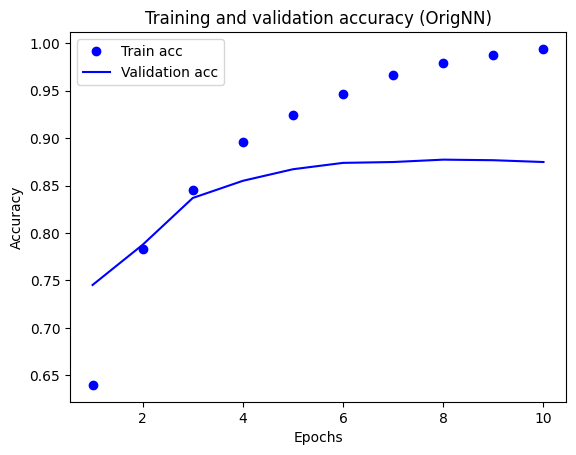

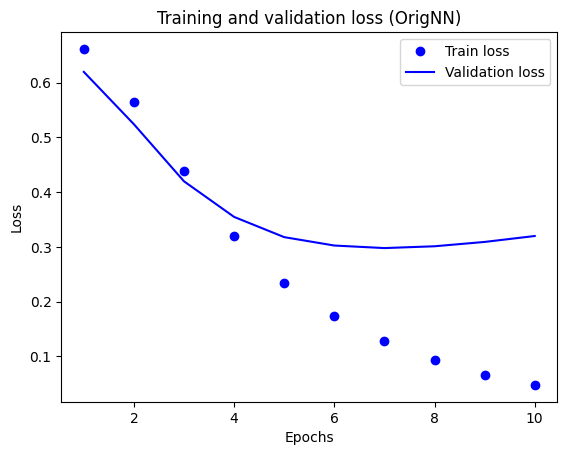

In [ ]:
# Plot the accuracy and loss curves for OrigNN
acc_orig = history_orig.history['accuracy']
val_acc_orig = history_orig.history['val_accuracy']
loss_orig = history_orig.history['loss']
val_loss_orig = history_orig.history['val_loss']
epochs_orig = range(1, len(acc_orig) + 1)

plt.plot(epochs_orig, acc_orig, 'bo', label='Train acc')
plt.plot(epochs_orig, val_acc_orig, 'b', label='Validation acc')
plt.title('Training and validation accuracy (OrigNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs_orig, loss_orig, 'bo', label='Train loss')
plt.plot(epochs_orig, val_loss_orig, 'b', label='Validation loss')
plt.title('Training and validation loss (OrigNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

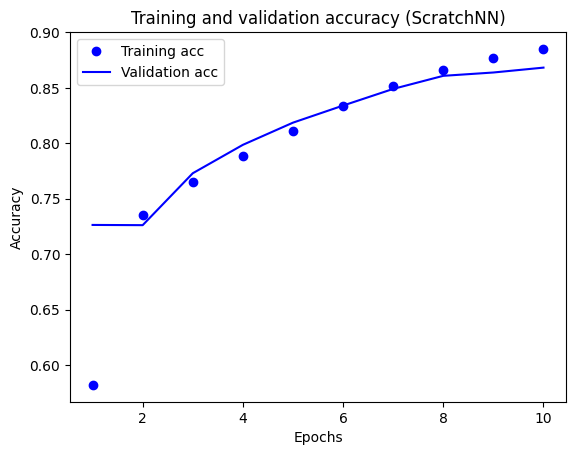

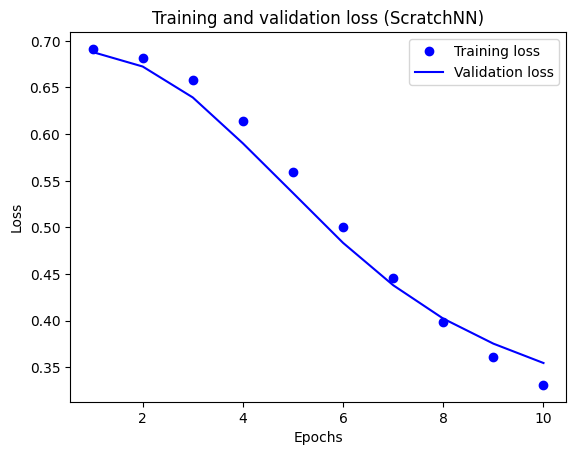

In [ ]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs_2 = range(1, len(acc_2) + 1)

plt.plot(epochs_2, acc_2, 'bo', label='Training acc')
plt.plot(epochs_2, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy (ScratchNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs_2, loss_2, 'bo', label='Training loss')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss (ScratchNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
N = 3

# Model 3. = DenseNNi

In [ ]:
model_3 = tf.keras.Sequential(name = 'DenseNNi')
model_3.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_3.add(tf.keras.layers.Dense((50 + 10 * N), activation='relu'))
model_3.add(tf.keras.layers.Dense(1))
model_3.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model_3.evaluate(test_examples, test_labels)

Epoch 1/10
30/30 [==============================] - 7s 196ms/step - loss: 0.6450 - accuracy: 0.6508 - val_loss: 0.5789 - val_accuracy: 0.7409
Epoch 2/10
30/30 [==============================] - 5s 183ms/step - loss: 0.4883 - accuracy: 0.8006 - val_loss: 0.4303 - val_accuracy: 0.8154
Epoch 3/10
30/30 [==============================] - 5s 181ms/step - loss: 0.3198 - accuracy: 0.8807 - val_loss: 0.3408 - val_accuracy: 0.8587
Epoch 4/10
30/30 [==============================] - 5s 166ms/step - loss: 0.2096 - accuracy: 0.9254 - val_loss: 0.3124 - val_accuracy: 0.8689
Epoch 5/10
30/30 [==============================] - 5s 174ms/step - loss: 0.1379 - accuracy: 0.9567 - val_loss: 0.3076 - val_accuracy: 0.8756
Epoch 6/10
30/30 [==============================] - 5s 182ms/step - loss: 0.0883 - accuracy: 0.9771 - val_loss: 0.3263 - val_accuracy: 0.8716
Epoch 7/10
30/30 [==============================] - 5s 153ms/step - loss: 0.0560 - accuracy: 0.9895 - val_loss: 0.3343 - val_accuracy: 0.8731
Epoch 

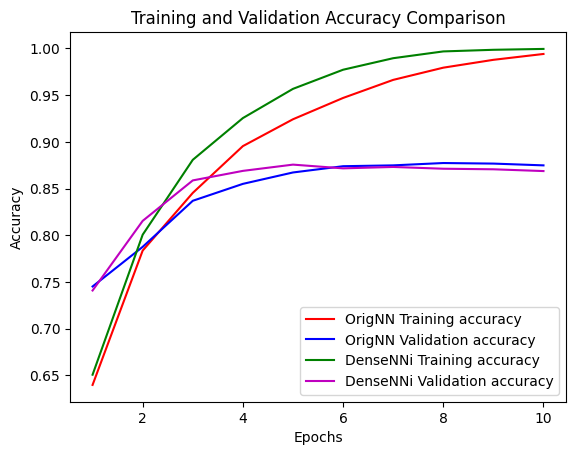

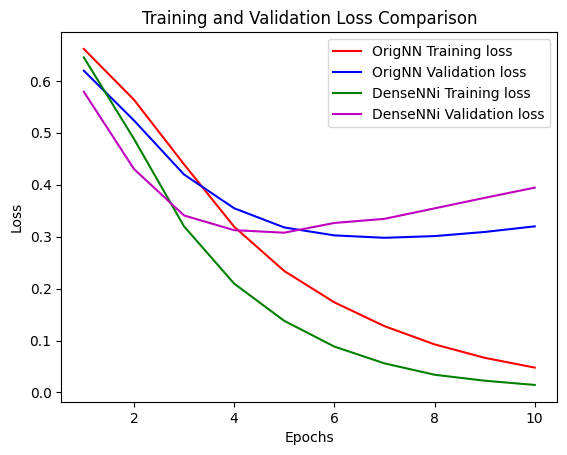

In [ ]:
orig_history = history_orig.history
# Get the history dictionary of the training process for OrigNN

dense_history = history_3.history
# Get the history dictionary of the training process for DenseNNi

orig_acc = orig_history['accuracy']
# Get the list of training accuracy values for OrigNN at each epoch

orig_val_acc = orig_history['val_accuracy']
# Get the list of validation accuracy values for OrigNN at each epoch

dense_acc = dense_history['accuracy']
# Get the list of training accuracy values for DenseNNi at each epoch

dense_val_acc = dense_history['val_accuracy']
# Get the list of validation accuracy values for DenseNNi at each epoch

epochs = range(1, len(orig_acc) + 1)

plt.plot(epochs, orig_acc, 'r', label='OrigNN Training accuracy')
plt.plot(epochs, orig_val_acc, 'b', label='OrigNN Validation accuracy')
plt.plot(epochs, dense_acc, 'g', label='DenseNNi Training accuracy')
plt.plot(epochs, dense_val_acc, 'm', label='DenseNNi Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
orig_loss = orig_history['loss']
orig_val_loss = orig_history['val_loss']

dense_loss = dense_history['loss']
dense_val_loss = dense_history['val_loss']

plt.plot(epochs, orig_loss, 'r', label='OrigNN Training loss')
plt.plot(epochs, orig_val_loss, 'b', label='OrigNN Validation loss')
plt.plot(epochs, dense_loss, 'g', label='DenseNNi Training loss')
plt.plot(epochs, dense_val_loss, 'm', label='DenseNNi Validation loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 4. = DenseNNii

In [ ]:
model_4 = tf.keras.Sequential(name = 'DenseNNii')
model_4.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_4.add(tf.keras.layers.Dense((50 + 10 * N), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_4.add(tf.keras.layers.Dense(1))
model_4.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
history_4 = model_4.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results_4 = model_4.evaluate(test_examples, test_labels)

Epoch 1/10
30/30 [==============================] - 7s 189ms/step - loss: 0.6954 - accuracy: 0.6628 - val_loss: 0.6316 - val_accuracy: 0.7336
Epoch 2/10
30/30 [==============================] - 5s 161ms/step - loss: 0.5473 - accuracy: 0.7890 - val_loss: 0.4947 - val_accuracy: 0.8081
Epoch 3/10
30/30 [==============================] - 5s 166ms/step - loss: 0.3924 - accuracy: 0.8689 - val_loss: 0.4063 - val_accuracy: 0.8469
Epoch 4/10
30/30 [==============================] - 4s 145ms/step - loss: 0.2838 - accuracy: 0.9139 - val_loss: 0.3695 - val_accuracy: 0.8614
Epoch 5/10
30/30 [==============================] - 4s 142ms/step - loss: 0.2105 - accuracy: 0.9461 - val_loss: 0.3582 - val_accuracy: 0.8687
Epoch 6/10
30/30 [==============================] - 5s 149ms/step - loss: 0.1573 - accuracy: 0.9689 - val_loss: 0.3533 - val_accuracy: 0.8736
Epoch 7/10
30/30 [==============================] - 4s 148ms/step - loss: 0.1200 - accuracy: 0.9829 - val_loss: 0.3613 - val_accuracy: 0.8732
Epoch 

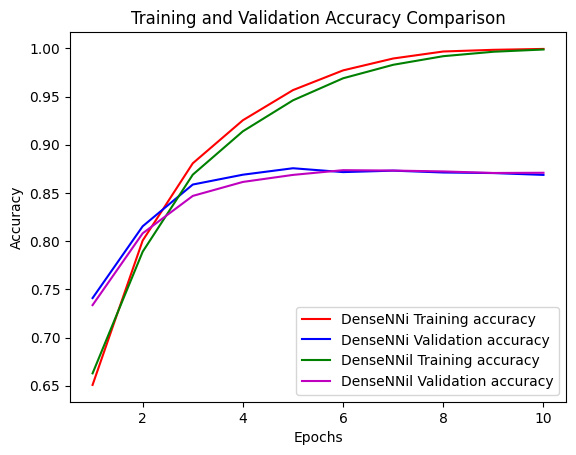

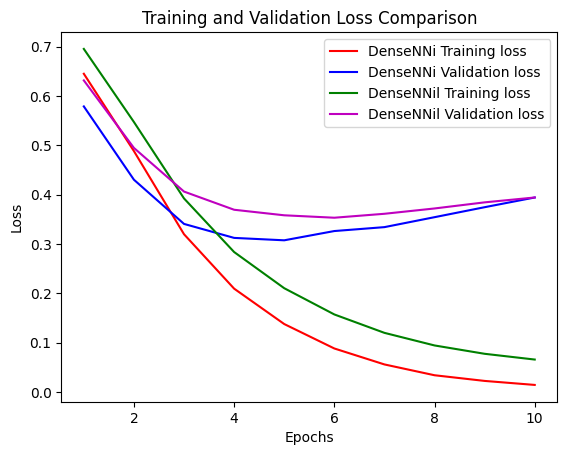

In [ ]:
dense_history_4 = history_4.history
# Get the history dictionary of the training process for DenseNNil

dense_acc_i = dense_history['accuracy']
# Get the list of training accuracy values for DenseNNi at each epoch

dense_val_acc_i = dense_history['val_accuracy']
# Get the list of validation accuracy values for DenseNNi at each epoch

dense_acc_il = dense_history_4['accuracy']
# Get the list of training accuracy values for DenseNNil at each epoch

dense_val_acc_il = dense_history_4['val_accuracy']
# Get the list of validation accuracy values for DenseNNil at each epoch
epochs = range(1, len(dense_acc_i) + 1)

plt.plot(epochs, dense_acc_i, 'r', label='DenseNNi Training accuracy')
plt.plot(epochs, dense_val_acc_i, 'b', label='DenseNNi Validation accuracy')
plt.plot(epochs, dense_acc_il, 'g', label='DenseNNil Training accuracy')
plt.plot(epochs, dense_val_acc_il, 'm', label='DenseNNil Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
dense_loss_i = dense_history['loss']
dense_val_loss_i = dense_history['val_loss']

dense_loss_il = dense_history_4['loss']
dense_val_loss_il = dense_history_4['val_loss']

plt.plot(epochs, dense_loss_i, 'r', label='DenseNNi Training loss')
plt.plot(epochs, dense_val_loss_i, 'b', label='DenseNNi Validation loss')
plt.plot(epochs, dense_loss_il, 'g', label='DenseNNil Training loss')
plt.plot(epochs, dense_val_loss_il, 'm', label='DenseNNil Validation loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Model 5. = DenseNNiii

In [ ]:
model_5 = tf.keras.Sequential(name = 'DenseNNiii')
model_5.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_5.add(tf.keras.layers.Dense((50 + 10 * N), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Regularized Dense layer
model_5.add(tf.keras.layers.Dense((50 + 10 * N), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # Regularized Dense layer
model_5.add(tf.keras.layers.Dense(1))
model_5.compile(optimizer='adam',
                       loss=tf.losses.BinaryCrossentropy(from_logits=True),
                       metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
history_5 = model_5.fit(partial_x_train,
                                      partial_y_train,
                                      epochs=10,
                                      batch_size=512,
                                      validation_data=(x_val, y_val),
                                      verbose=1)

Epoch 1/10
30/30 [==============================] - 7s 192ms/step - loss: 0.7585 - accuracy: 0.6555 - val_loss: 0.6517 - val_accuracy: 0.7507
Epoch 2/10
30/30 [==============================] - 5s 161ms/step - loss: 0.5266 - accuracy: 0.8219 - val_loss: 0.4861 - val_accuracy: 0.8285
Epoch 3/10
30/30 [==============================] - 5s 165ms/step - loss: 0.3521 - accuracy: 0.8982 - val_loss: 0.4255 - val_accuracy: 0.8552
Epoch 4/10
30/30 [==============================] - 5s 156ms/step - loss: 0.2459 - accuracy: 0.9455 - val_loss: 0.4202 - val_accuracy: 0.8615
Epoch 5/10
30/30 [==============================] - 5s 155ms/step - loss: 0.1728 - accuracy: 0.9736 - val_loss: 0.4323 - val_accuracy: 0.8646
Epoch 6/10
30/30 [==============================] - 5s 172ms/step - loss: 0.1258 - accuracy: 0.9898 - val_loss: 0.4527 - val_accuracy: 0.8645
Epoch 7/10
30/30 [==============================] - 4s 138ms/step - loss: 0.0984 - accuracy: 0.9971 - val_loss: 0.4817 - val_accuracy: 0.8635
Epoch 

In [ ]:
results_5 = model_5.evaluate(test_examples, test_labels)

782/782 [==============================] - 4s 6ms/step - loss: 0.5701 - accuracy: 0.8460


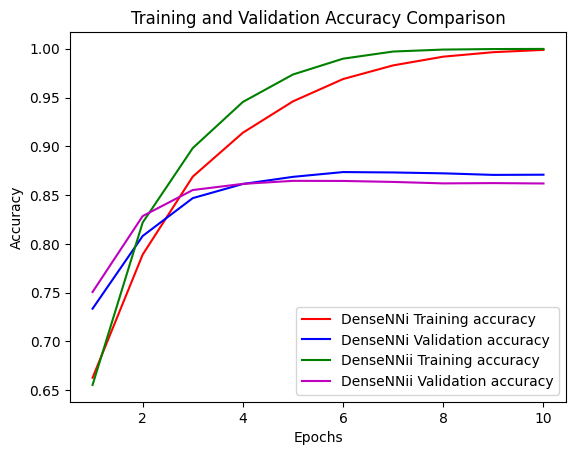

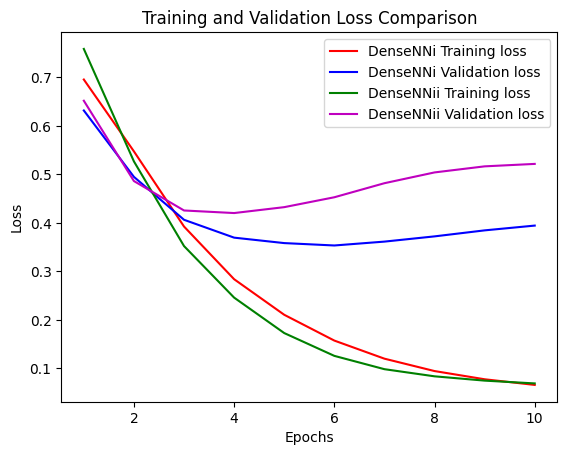

In [ ]:
dense_history_5 = history_5.history
# Get the history dictionary of the training process for DenseNNii

dense_acc_i = dense_history_4['accuracy']
# Get the list of training accuracy values for DenseNNi at each epoch

dense_val_acc_i = dense_history_4['val_accuracy']
# Get the list of validation accuracy values for DenseNNi at each epoch

dense_acc_ii = dense_history_5['accuracy']
# Get the list of training accuracy values for DenseNNii at each epoch

dense_val_acc_ii = dense_history_5['val_accuracy']
# Get the list of validation accuracy values for DenseNNii at each epoch

epochs = range(1, len(dense_acc_i) + 1)

plt.plot(epochs, dense_acc_i, 'r', label='DenseNNi Training accuracy')
plt.plot(epochs, dense_val_acc_i, 'b', label='DenseNNi Validation accuracy')
plt.plot(epochs, dense_acc_ii, 'g', label='DenseNNii Training accuracy')
plt.plot(epochs, dense_val_acc_ii, 'm', label='DenseNNii Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
dense_loss_i = dense_history_4['loss']
dense_val_loss_i = dense_history_4['val_loss']

dense_loss_ii = dense_history_5['loss']
dense_val_loss_ii = dense_history_5['val_loss']

plt.plot(epochs, dense_loss_i, 'r', label='DenseNNi Training loss')
plt.plot(epochs, dense_val_loss_i, 'b', label='DenseNNi Validation loss')
plt.plot(epochs, dense_loss_ii, 'g', label='DenseNNii Training loss')
plt.plot(epochs, dense_val_loss_ii, 'm', label='DenseNNii Validation loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Model 6. = DropNNi

In [ ]:
model_6 = tf.keras.Sequential(name = 'DropNNi')
model_6.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_6.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Regularized Dense layer
model_6.add(tf.keras.layers.Dropout(0.2))  # Dropout layer
model_6.add(tf.keras.layers.Dense(1))
model_6.compile(optimizer='adam',
                     loss=tf.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
history_6 = model_6.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=10,
                                  batch_size=512,
                                  validation_data=(x_val, y_val),
                                  verbose=1)

Epoch 1/10
30/30 [==============================] - 7s 190ms/step - loss: 0.6968 - accuracy: 0.6383 - val_loss: 0.6312 - val_accuracy: 0.7474
Epoch 2/10
30/30 [==============================] - 5s 157ms/step - loss: 0.5625 - accuracy: 0.7774 - val_loss: 0.5065 - val_accuracy: 0.8055
Epoch 3/10
30/30 [==============================] - 5s 171ms/step - loss: 0.4177 - accuracy: 0.8541 - val_loss: 0.4091 - val_accuracy: 0.8434
Epoch 4/10
30/30 [==============================] - 5s 152ms/step - loss: 0.3082 - accuracy: 0.9030 - val_loss: 0.3678 - val_accuracy: 0.8608
Epoch 5/10
30/30 [==============================] - 5s 150ms/step - loss: 0.2343 - accuracy: 0.9356 - val_loss: 0.3508 - val_accuracy: 0.8680
Epoch 6/10
30/30 [==============================] - 5s 164ms/step - loss: 0.1799 - accuracy: 0.9590 - val_loss: 0.3500 - val_accuracy: 0.8719
Epoch 7/10
30/30 [==============================] - 4s 148ms/step - loss: 0.1402 - accuracy: 0.9744 - val_loss: 0.3526 - val_accuracy: 0.8718
Epoch 

In [ ]:
results_6 = model_6.evaluate(test_examples, test_labels)

782/782 [==============================] - 4s 5ms/step - loss: 0.4198 - accuracy: 0.8558


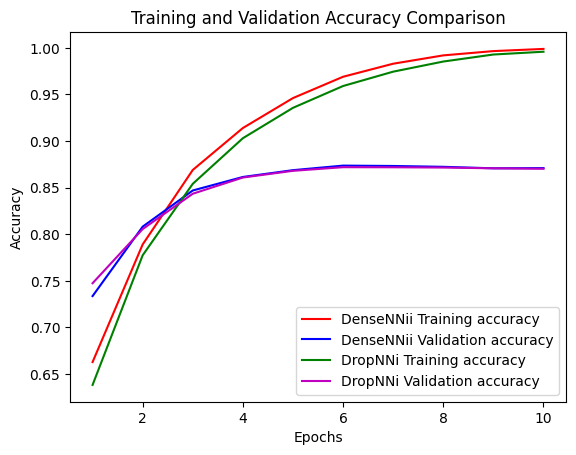

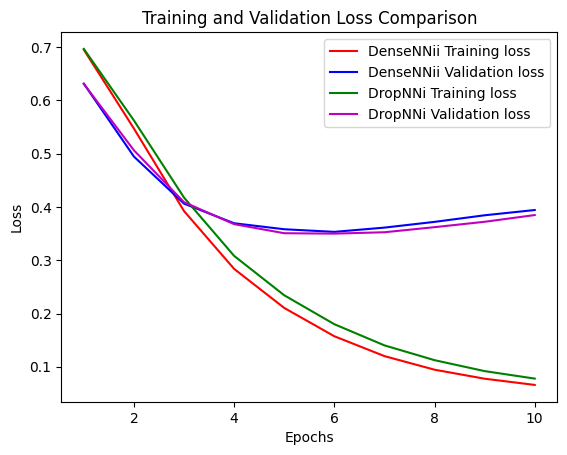

In [ ]:
drop_history_dict_i = history_6.history
# Get the history dictionary of the training process for DropNNi

dense_acc_ii = dense_history_4['accuracy']
# Get the list of training accuracy values for DenseNNi at each epoch

dense_val_acc_ii = dense_history_4['val_accuracy']
# Get the list of validation accuracy values for DenseNNi at each epoch

drop_acc_i = drop_history_dict_i['accuracy']
# Get the list of training accuracy values for DropNNi at each epoch

drop_val_acc_i = drop_history_dict_i['val_accuracy']
# Get the list of validation accuracy values for DropNNi at each epoch

epochs = range(1, len(dense_acc_ii) + 1)

plt.plot(epochs, dense_acc_ii, 'r', label='DenseNNii Training accuracy')
plt.plot(epochs, dense_val_acc_ii, 'b', label='DenseNNii Validation accuracy')
plt.plot(epochs, drop_acc_i, 'g', label='DropNNi Training accuracy')
plt.plot(epochs, drop_val_acc_i, 'm', label='DropNNi Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
dense_loss_ii = dense_history_4['loss']
dense_val_loss_ii = dense_history_4['val_loss']

drop_loss_i = drop_history_dict_i['loss']
drop_val_loss_i = drop_history_dict_i['val_loss']

plt.plot(epochs, dense_loss_ii, 'r', label='DenseNNii Training loss')
plt.plot(epochs, dense_val_loss_ii, 'b', label='DenseNNii Validation loss')
plt.plot(epochs, drop_loss_i, 'g', label='DropNNi Training loss')
plt.plot(epochs, drop_val_loss_i, 'm', label='DropNNi Validation loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 7. = DropNNii

In [ ]:
model_7 = tf.keras.Sequential(name = 'DropNNii')
model_7.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_7.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Regularized Dense layer
model_7.add(tf.keras.layers.Dropout((0.3 + 0.05 * N)))  # Dropout layer
model_7.add(tf.keras.layers.Dense(1))
model_7.compile(optimizer='adam',
                     loss=tf.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
history_7 = model_7.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=10,
                                  batch_size=512,
                                  validation_data=(x_val, y_val),
                                  verbose=1)

Epoch 1/10
30/30 [==============================] - 6s 173ms/step - loss: 0.6936 - accuracy: 0.6284 - val_loss: 0.6275 - val_accuracy: 0.7394
Epoch 2/10
30/30 [==============================] - 6s 209ms/step - loss: 0.5733 - accuracy: 0.7593 - val_loss: 0.5109 - val_accuracy: 0.8043
Epoch 3/10
30/30 [==============================] - 4s 144ms/step - loss: 0.4399 - accuracy: 0.8427 - val_loss: 0.4188 - val_accuracy: 0.8418
Epoch 4/10
30/30 [==============================] - 5s 153ms/step - loss: 0.3384 - accuracy: 0.8896 - val_loss: 0.3755 - val_accuracy: 0.8572
Epoch 5/10
30/30 [==============================] - 4s 148ms/step - loss: 0.2584 - accuracy: 0.9214 - val_loss: 0.3535 - val_accuracy: 0.8675
Epoch 6/10
30/30 [==============================] - 4s 129ms/step - loss: 0.2028 - accuracy: 0.9503 - val_loss: 0.3471 - val_accuracy: 0.8710
Epoch 7/10
30/30 [==============================] - 4s 122ms/step - loss: 0.1598 - accuracy: 0.9670 - val_loss: 0.3532 - val_accuracy: 0.8718
Epoch 

THe saturartion point of the model appeared at the 7th epoch and after that it started to overfit and as we can see the degrading results of the model in validation accuracies 

In [ ]:
results_7 = model_7.evaluate(test_examples, test_labels)

782/782 [==============================] - 3s 4ms/step - loss: 0.4088 - accuracy: 0.8582


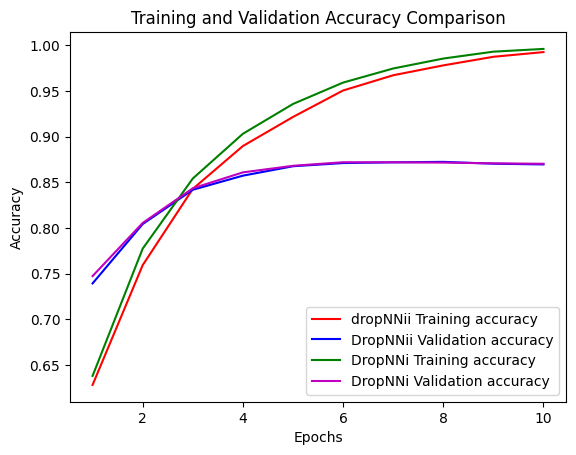

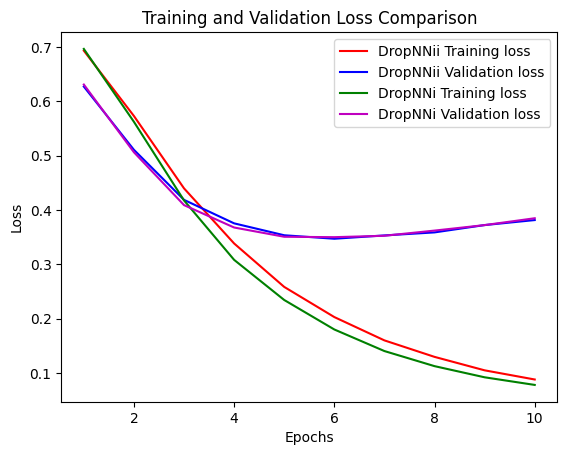

In [ ]:
drop_history_dict_ii = history_7.history
# Get the history dictionary of the training process for DropNNii

drop_acc_ii = drop_history_dict_ii['accuracy']
# Get the list of training accuracy values for DropNNii at each epoch

drop_val_acc_ii = drop_history_dict_ii['val_accuracy']
# Get the list of validation accuracy values for DropNNii at each epoch

drop_acc_i = drop_history_dict_i['accuracy']
# Get the list of training accuracy values for DropNNi at each epoch

drop_val_acc_i = drop_history_dict_i['val_accuracy']
# Get the list of validation accuracy values for DropNNi at each epoch

epochs = range(1, len(drop_acc_ii) + 1)

plt.plot(epochs, drop_acc_ii, 'r', label='dropNNii Training accuracy')
plt.plot(epochs, drop_val_acc_ii, 'b', label='DropNNii Validation accuracy')
plt.plot(epochs, drop_acc_i, 'g', label='DropNNi Training accuracy')
plt.plot(epochs, drop_val_acc_i, 'm', label='DropNNi Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
drop_loss_ii = drop_history_dict_ii['loss']
drop_val_loss_ii = drop_history_dict_ii['val_loss']

drop_loss_i = drop_history_dict_i['loss']
drop_val_loss_i = drop_history_dict_i['val_loss']

plt.plot(epochs, drop_loss_ii, 'r', label='DropNNii Training loss')
plt.plot(epochs, drop_val_loss_ii, 'b', label='DropNNii Validation loss')
plt.plot(epochs, drop_loss_i, 'g', label='DropNNi Training loss')
plt.plot(epochs, drop_val_loss_i, 'm', label='DropNNi Validation loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Comparing all the model and finding the one with the best accuracy

In [ ]:
model_list = [model_orig, model_2, model_3, model_4, model_5, model_6, model_7]
model_names = ['OrigNN', 'DenseNNi', 'DenseNNii', 'DenseNNiii', 'DropNNi', 'DropNNii']
model_accuracies = []

for model in model_list:
    if model == model_2:
        accuracy = model.evaluate(test_padded, test_labels)[1]
    else:
        accuracy = model.evaluate(test_examples, test_labels)[1]
    model_accuracies.append(accuracy)

# Find the index of the best performing model
max_accuracy = max(model_accuracies)
best_model_index = model_accuracies.index(max_accuracy)-1
print(best_model_index)
best_model = model_list[best_model_index]
best_model_name = model_names[best_model_index]

# Get the predicted sentiment scores for the test set using the best model
if best_model == model_2:
    scores = best_model.predict(test_padded)
else:
    scores = best_model.predict(test_examples)

# Sort the scores in ascending order
sorted_indices = np.argsort(scores.flatten())

# Get the 5 most positive and 5 most negative reviews
most_positive_reviews = [test_examples[i] for i in sorted_indices[-5:]]
most_negative_reviews = [test_examples[i] for i in sorted_indices[:5]]

print("Best Model: ", best_model_name)

782/782 [==============================] - 4s 5ms/step - loss: 0.4088 - accuracy: 0.8582
-1
782/782 [==============================] - 3s 3ms/step
Best Model:  DropNNii
Most Positive Reviews:
b'Universal Studios version of "Flipper" (1996) is a great heartwarming film for the entire family with good values and sentimentality. It is the story of Sandy Ricks, a teenager from Chicago who reluctantly spends his vacation with his Uncle Porter Ricks in the Bahamas. This ultimately changes the teenagers life and he grows up in the process. He learns to appreciate nature and to have a respect for the environment. I grew up in the 1960\'s and the NBC television show "Flipper" was my favorite childhood show. Elijah Wood is perfectly cast as a 1990\'s Sandy Ricks and gives an excellent performance. As much as I liked the NBC television show and MGM theatrical feature films with Luke Halpin as Sandy in the 1960\'s I liked this feature the best! I feel Elijah Wood is the best Sandy Ricks. With resp

In [ ]:
best_model_name

'DropNNii'

# Model 8.
Adding dropout layer to the best model found and training it and coparing it to the best model.

In [ ]:
model_8 = tf.keras.Sequential(name='NNBestDrop')
model_8.add(hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True))
model_8.add(tf.keras.layers.Dense(16, activation='relu'))
model_8.add(tf.keras.layers.Dropout((0.3 + 0.05 * N)))
model_8.add(tf.keras.layers.Dropout(0.2))
model_8.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Apply sigmoid activation for binary output
model_8.compile(optimizer='adam',
                        loss=tf.losses.BinaryCrossentropy(),
                        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
history_NN_best_drop = model_8.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512,validation_data=(x_val, y_val),verbose=1)
results_NN_best_drop = model_8.evaluate(test_examples, test_labels)

Epoch 1/10
30/30 [==============================] - 6s 177ms/step - loss: 0.6960 - accuracy: 0.5451 - val_loss: 0.6509 - val_accuracy: 0.6719
Epoch 2/10
30/30 [==============================] - 4s 145ms/step - loss: 0.6214 - accuracy: 0.6713 - val_loss: 0.5725 - val_accuracy: 0.7535
Epoch 3/10
30/30 [==============================] - 4s 150ms/step - loss: 0.5429 - accuracy: 0.7447 - val_loss: 0.4911 - val_accuracy: 0.8113
Epoch 4/10
30/30 [==============================] - 6s 184ms/step - loss: 0.4529 - accuracy: 0.8088 - val_loss: 0.4144 - val_accuracy: 0.8395
Epoch 5/10
30/30 [==============================] - 4s 138ms/step - loss: 0.3739 - accuracy: 0.8506 - val_loss: 0.3608 - val_accuracy: 0.8533
Epoch 6/10
30/30 [==============================] - 4s 141ms/step - loss: 0.3026 - accuracy: 0.8818 - val_loss: 0.3298 - val_accuracy: 0.8619
Epoch 7/10
30/30 [==============================] - 4s 134ms/step - loss: 0.2508 - accuracy: 0.9071 - val_loss: 0.3136 - val_accuracy: 0.8679
Epoch 

In [ ]:
accuracy_best_drop = model_8.evaluate(test_examples, test_labels)[1]

782/782 [==============================] - 4s 5ms/step - loss: 0.3267 - accuracy: 0.8614


In [ ]:
# Get the probabilities assigned by NNBest model
probabilities_best = best_model.predict(test_examples[100:120])

# Get the probabilities assigned by NNBestDrop model
probabilities_best_drop = model_8.predict(test_examples[100:120])

1/1 [==============================] - 0s 73ms/step
